# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from IPython.display import SVG, display

def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "python").exists() and (candidate / "golang").exists():
            return candidate
    return start


repo_root = find_repo_root(Path.cwd())
python_path = repo_root / "python"
if str(python_path) not in sys.path:
    sys.path.insert(0, str(python_path))

from extra_boost_py.booster import BoosterParams, ExtraBooster
from extra_boost_py.go_lib import build_shared
from extra_boost_py.metrics import roc_auc_score
from catboost import CatBoostClassifier
import xgboost as xgb


# AI

In [2]:
%load_ext jupyter_ai_magics

In [3]:
%ai list openai-chat

| Provider | Environment variable | Set? | Models |
|----------|----------------------|------|--------|
| `openai-chat` | `OPENAI_API_KEY` | <abbr title="You have set this environment variable, so you can use this provider's models.">✅</abbr> | <ul><li>`openai-chat:gpt-3.5-turbo`</li><li>`openai-chat:gpt-3.5-turbo-1106`</li><li>`openai-chat:gpt-4`</li><li>`openai-chat:gpt-4-turbo`</li><li>`openai-chat:gpt-4-turbo-preview`</li><li>`openai-chat:gpt-4-0613`</li><li>`openai-chat:gpt-4-0125-preview`</li><li>`openai-chat:gpt-4-1106-preview`</li><li>`openai-chat:gpt-4o`</li><li>`openai-chat:gpt-4o-2024-11-20`</li><li>`openai-chat:gpt-4o-mini`</li><li>`openai-chat:chatgpt-4o-latest`</li></ul> |


# Dataset for logloss

In [4]:
n = 100000
alpha = 0.5

rng = np.random.default_rng(0)

L = rng.choice([0, 1], size=n, p=[1 - alpha, alpha])

t = np.linspace(0, 1, n)

gamma_up = 0.5 + t
gamma_down = 1.5 - t

beta = 2 * 1 / 16

threshold_one_up = beta * gamma_up
threshold_one_down = beta * gamma_down

threshold_two_up = (beta - alpha * beta * gamma_up) / (1 - alpha)
threshold_two_down = (beta - alpha * beta * gamma_down) / (1 - alpha)

threshold_up = np.where(L == 1, threshold_one_up, threshold_two_up)
threshold_down = np.where(L == 1, threshold_one_down, threshold_two_down)

F_up = (rng.random((n, 8)) < threshold_up[:, None]).astype(int)
F_down = (rng.random((n, 8)) < threshold_down[:, None]).astype(int)


In [5]:
F_up.shape, F_down.shape

((100000, 8), (100000, 8))

In [6]:
output_dir = repo_root / 'notebooks' / 'logloss_mode'
output_dir.mkdir(parents=True, exist_ok=True)

data = {
    'label': L,
    't': t,
}

data.update({f'f_up_{i}': F_up[:, i] for i in range(F_up.shape[1])})
data.update({f'f_down_{i}': F_down[:, i] for i in range(F_down.shape[1])})

df = pd.DataFrame(data)

full_path = output_dir / 'logloss_full.csv'
df.to_csv(full_path, index=False)

train_mask = df['t'] < 0.4
train_df = df[train_mask].sample(frac=1, random_state=0).reset_index(drop=True)
test_df = df[~train_mask].sample(frac=1, random_state=0).reset_index(drop=True)

train_path = output_dir / 'logloss_train.csv'
test_path = output_dir / 'logloss_test.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

{
    'full_rows': len(df),
    'train_rows': len(train_df),
    'test_rows': len(test_df),
    'train_t_max': float(train_df['t'].max()),
    'test_t_min': float(test_df['t'].min()),
    'paths': {
        'full': str(full_path),
        'train': str(train_path),
        'test': str(test_path),
    },
}


{'full_rows': 100000,
 'train_rows': 40000,
 'test_rows': 60000,
 'train_t_max': 0.3999939999399994,
 'test_t_min': 0.4000040000400004,
 'paths': {'full': '/home/tarstars/prj/extra_bridged_boosting/notebooks/logloss_mode/logloss_full.csv',
  'train': '/home/tarstars/prj/extra_bridged_boosting/notebooks/logloss_mode/logloss_train.csv',
  'test': '/home/tarstars/prj/extra_bridged_boosting/notebooks/logloss_mode/logloss_test.csv'}}

# EDA

In [7]:
df.shape

(100000, 18)

In [8]:
df.head()

,label,t,f_up_0,f_up_1,f_up_2,f_up_3,f_up_4,f_up_5,f_up_6,f_up_7,f_down_0,f_down_1,f_down_2,f_down_3,f_down_4,f_down_5,f_down_6,f_down_7
0,1,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0.00001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.00002,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0.00003,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.00004,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
df.describe()

,label,t,f_up_0,f_up_1,f_up_2,f_up_3,f_up_4,f_up_5,f_up_6,f_up_7,f_down_0,f_down_1,f_down_2,f_down_3,f_down_4,f_down_5,f_down_6,f_down_7
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.499020,0.500000,0.124600,0.125740,0.124200,0.126160,0.124990,0.124630,0.125100,0.123710,0.12426,0.124530,0.123580,0.128140,0.124610,0.125210,0.125170,0.125170
std,0.500002,0.288679,0.330266,0.331558,0.329811,0.332031,0.330709,0.330301,0.330834,0.329252,0.32988,0.330187,0.329103,0.334247,0.330278,0.330959,0.330913,0.330913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df[df["t"] < 0.1]["label"].mean()

np.float64(0.501)

In [11]:
df[df["t"] < 0.1][df["f_down_0"] == 1]["label"].mean()

/tmp/ipykernel_44130/1761783625.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["t"] < 0.1][df["f_down_0"] == 1]["label"].mean()


np.float64(0.7122752150117279)

In [12]:
df[df["t"] < 0.1][df["f_up_0"] == 1]["label"].mean()

/tmp/ipykernel_44130/3316816353.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["t"] < 0.1][df["f_up_0"] == 1]["label"].mean()


np.float64(0.25693893735130846)

# Lift vs. time


/tmp/ipykernel_44130/3990342164.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_rate_by_bin = df.groupby('t_bin')['label'].mean()
/tmp/ipykernel_44130/3990342164.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  factor_rate = df[df[factor] == 1].groupby('t_bin')['label'].mean()


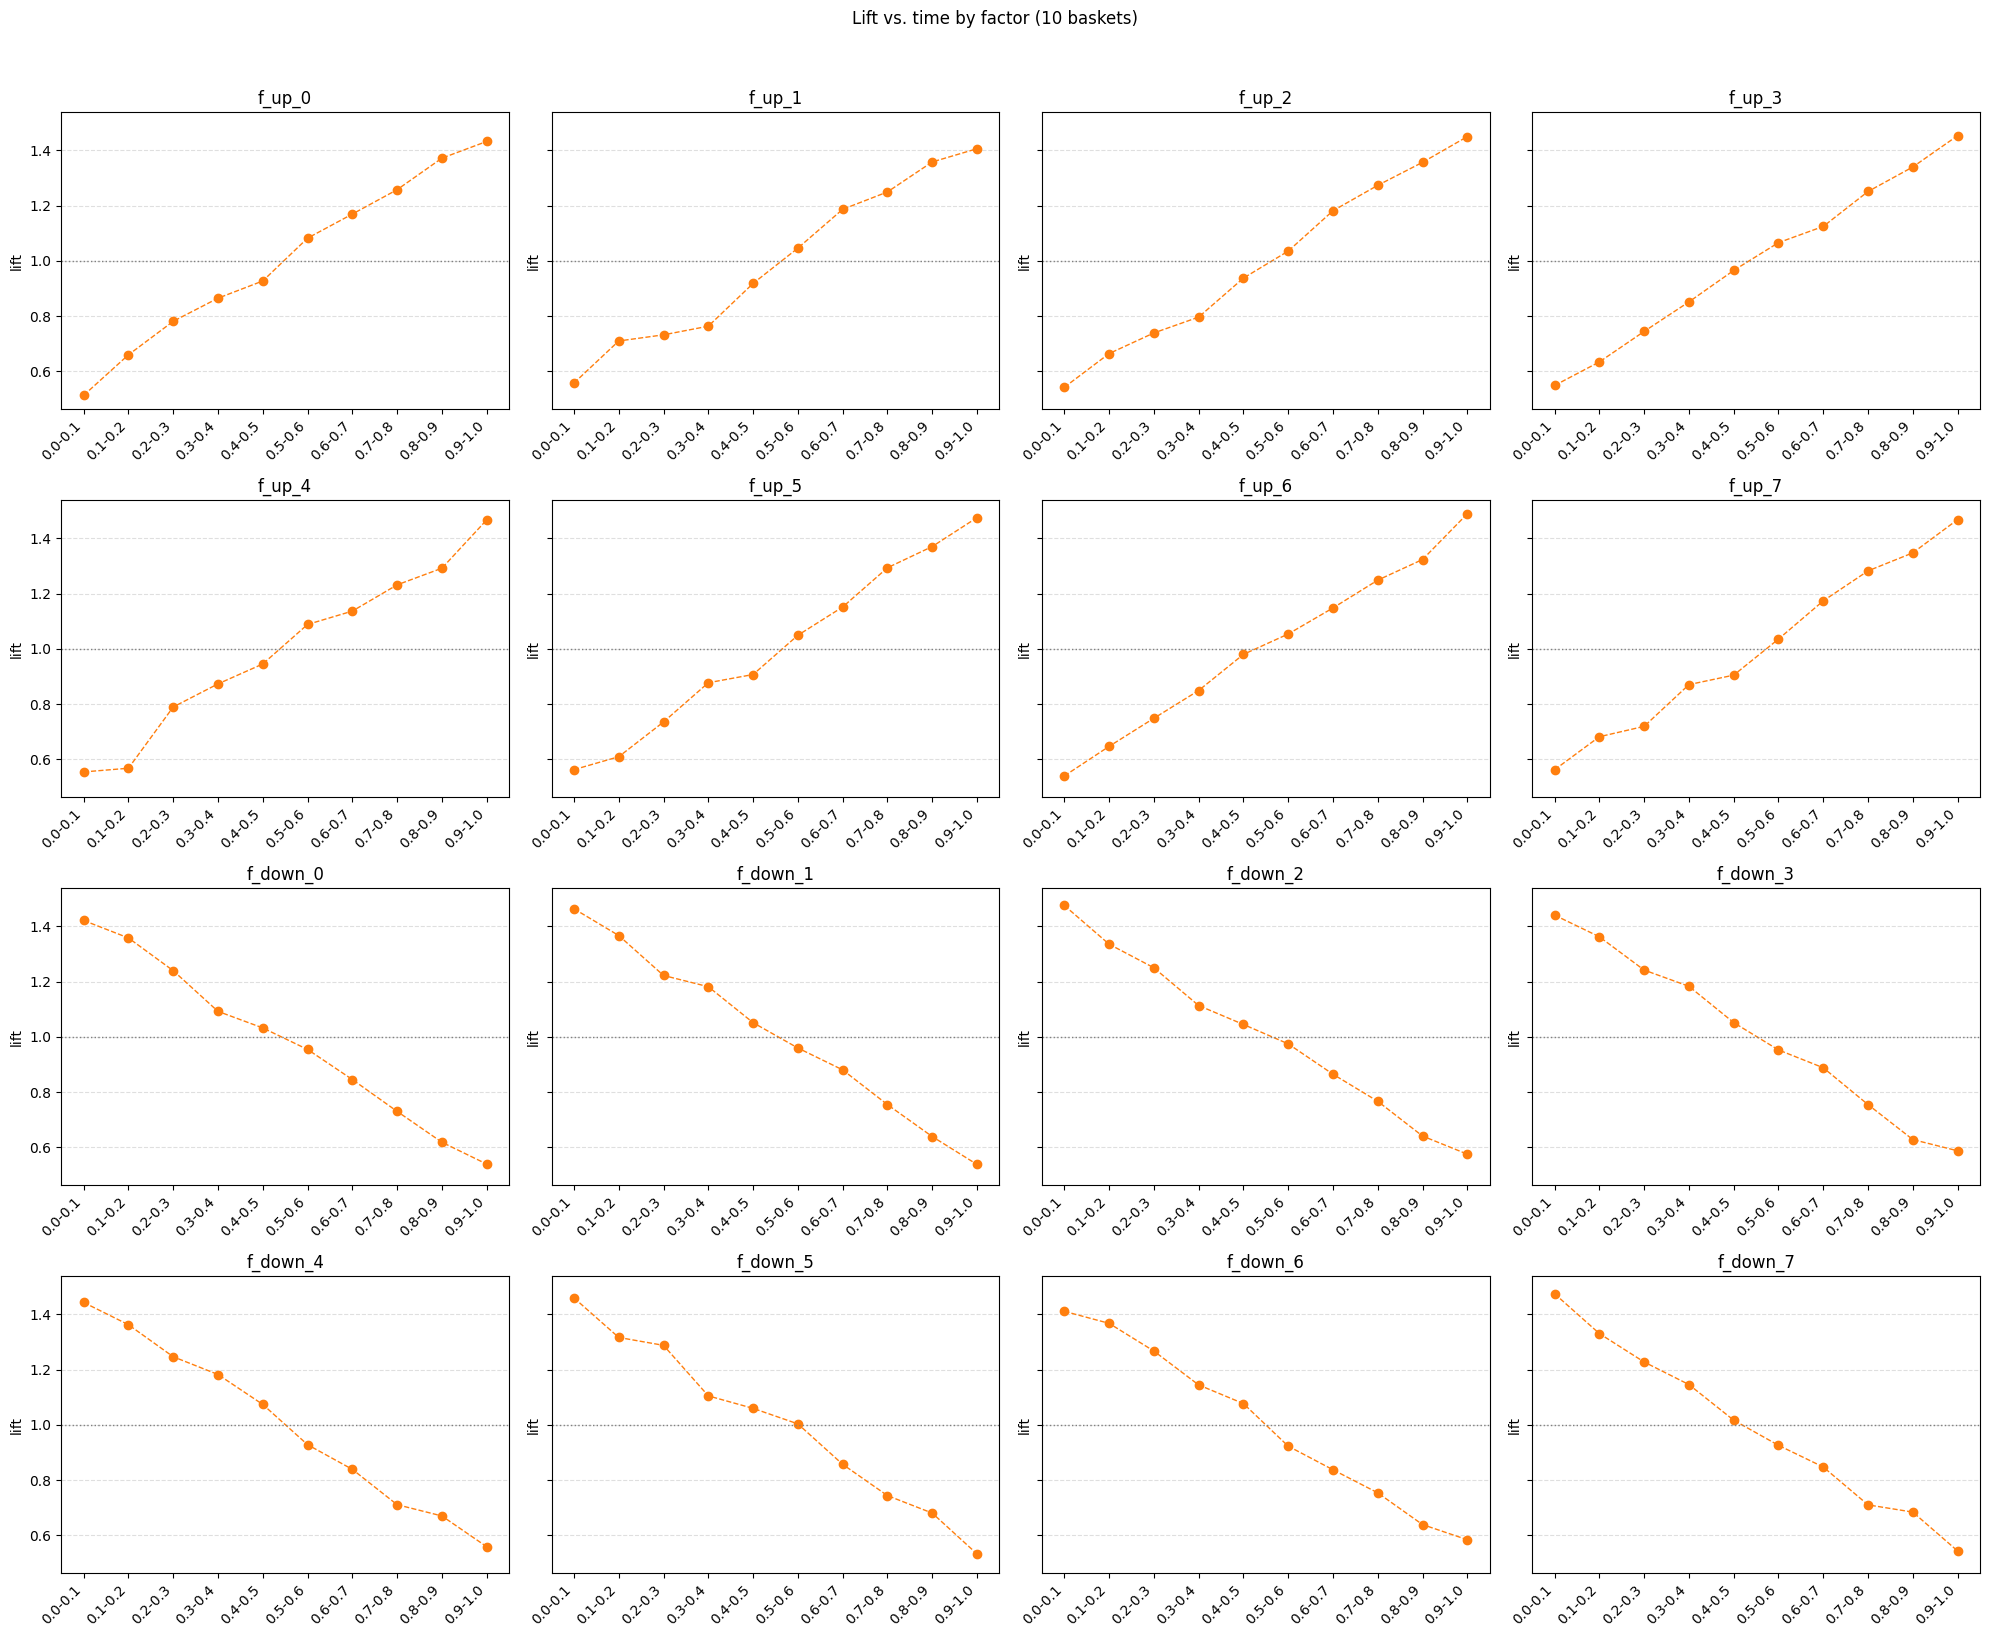

In [13]:

bins = np.linspace(0, 1, 11)
bin_labels = [f"{bins[i]:.1f}-{bins[i + 1]:.1f}" for i in range(len(bins) - 1)]

df = df.copy()
df['t_bin'] = pd.cut(df['t'], bins=bins, labels=bin_labels, include_lowest=True, right=True)

factors = [c for c in df.columns if c.startswith('f_up_') or c.startswith('f_down_')]
base_rate_by_bin = df.groupby('t_bin')['label'].mean()

lift_by_factor = {}
for factor in factors:
    factor_rate = df[df[factor] == 1].groupby('t_bin')['label'].mean()
    lift_by_factor[factor] = factor_rate / base_rate_by_bin

fig, axes = plt.subplots(4, 4, figsize=(20, 16), sharey=True)
axes = axes.flatten()
positions = np.arange(len(bin_labels))

for ax, factor in zip(axes, factors):
    lifts = lift_by_factor[factor].reindex(bin_labels).astype(float)
    box_data = [[v if not np.isnan(v) else np.nan] for v in lifts]
    ax.boxplot(box_data, positions=positions, widths=0.08, showfliers=False)
    ax.plot(positions, lifts, marker='o', linestyle='--', color='C1', linewidth=1)
    ax.axhline(1.0, color='gray', linestyle=':', linewidth=1)
    ax.set_title(factor)
    ax.set_xticks(positions)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    ax.set_ylabel('lift')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.margins(x=0.05)

for ax in axes[len(factors):]:
    ax.axis('off')

fig.suptitle('Lift vs. time by factor (10 baskets)', y=1.02)
fig.tight_layout()
plt.show()


/tmp/ipykernel_44130/3241789281.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_stats = df.groupby('t_bin')['label'].agg(['mean', 'size'])
/tmp/ipykernel_44130/3241789281.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('t_bin')['label']
/tmp/ipykernel_44130/3241789281.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('t_bin')['label']
/tmp/ipykernel_44130/3241789281.py:22: FutureWarnin

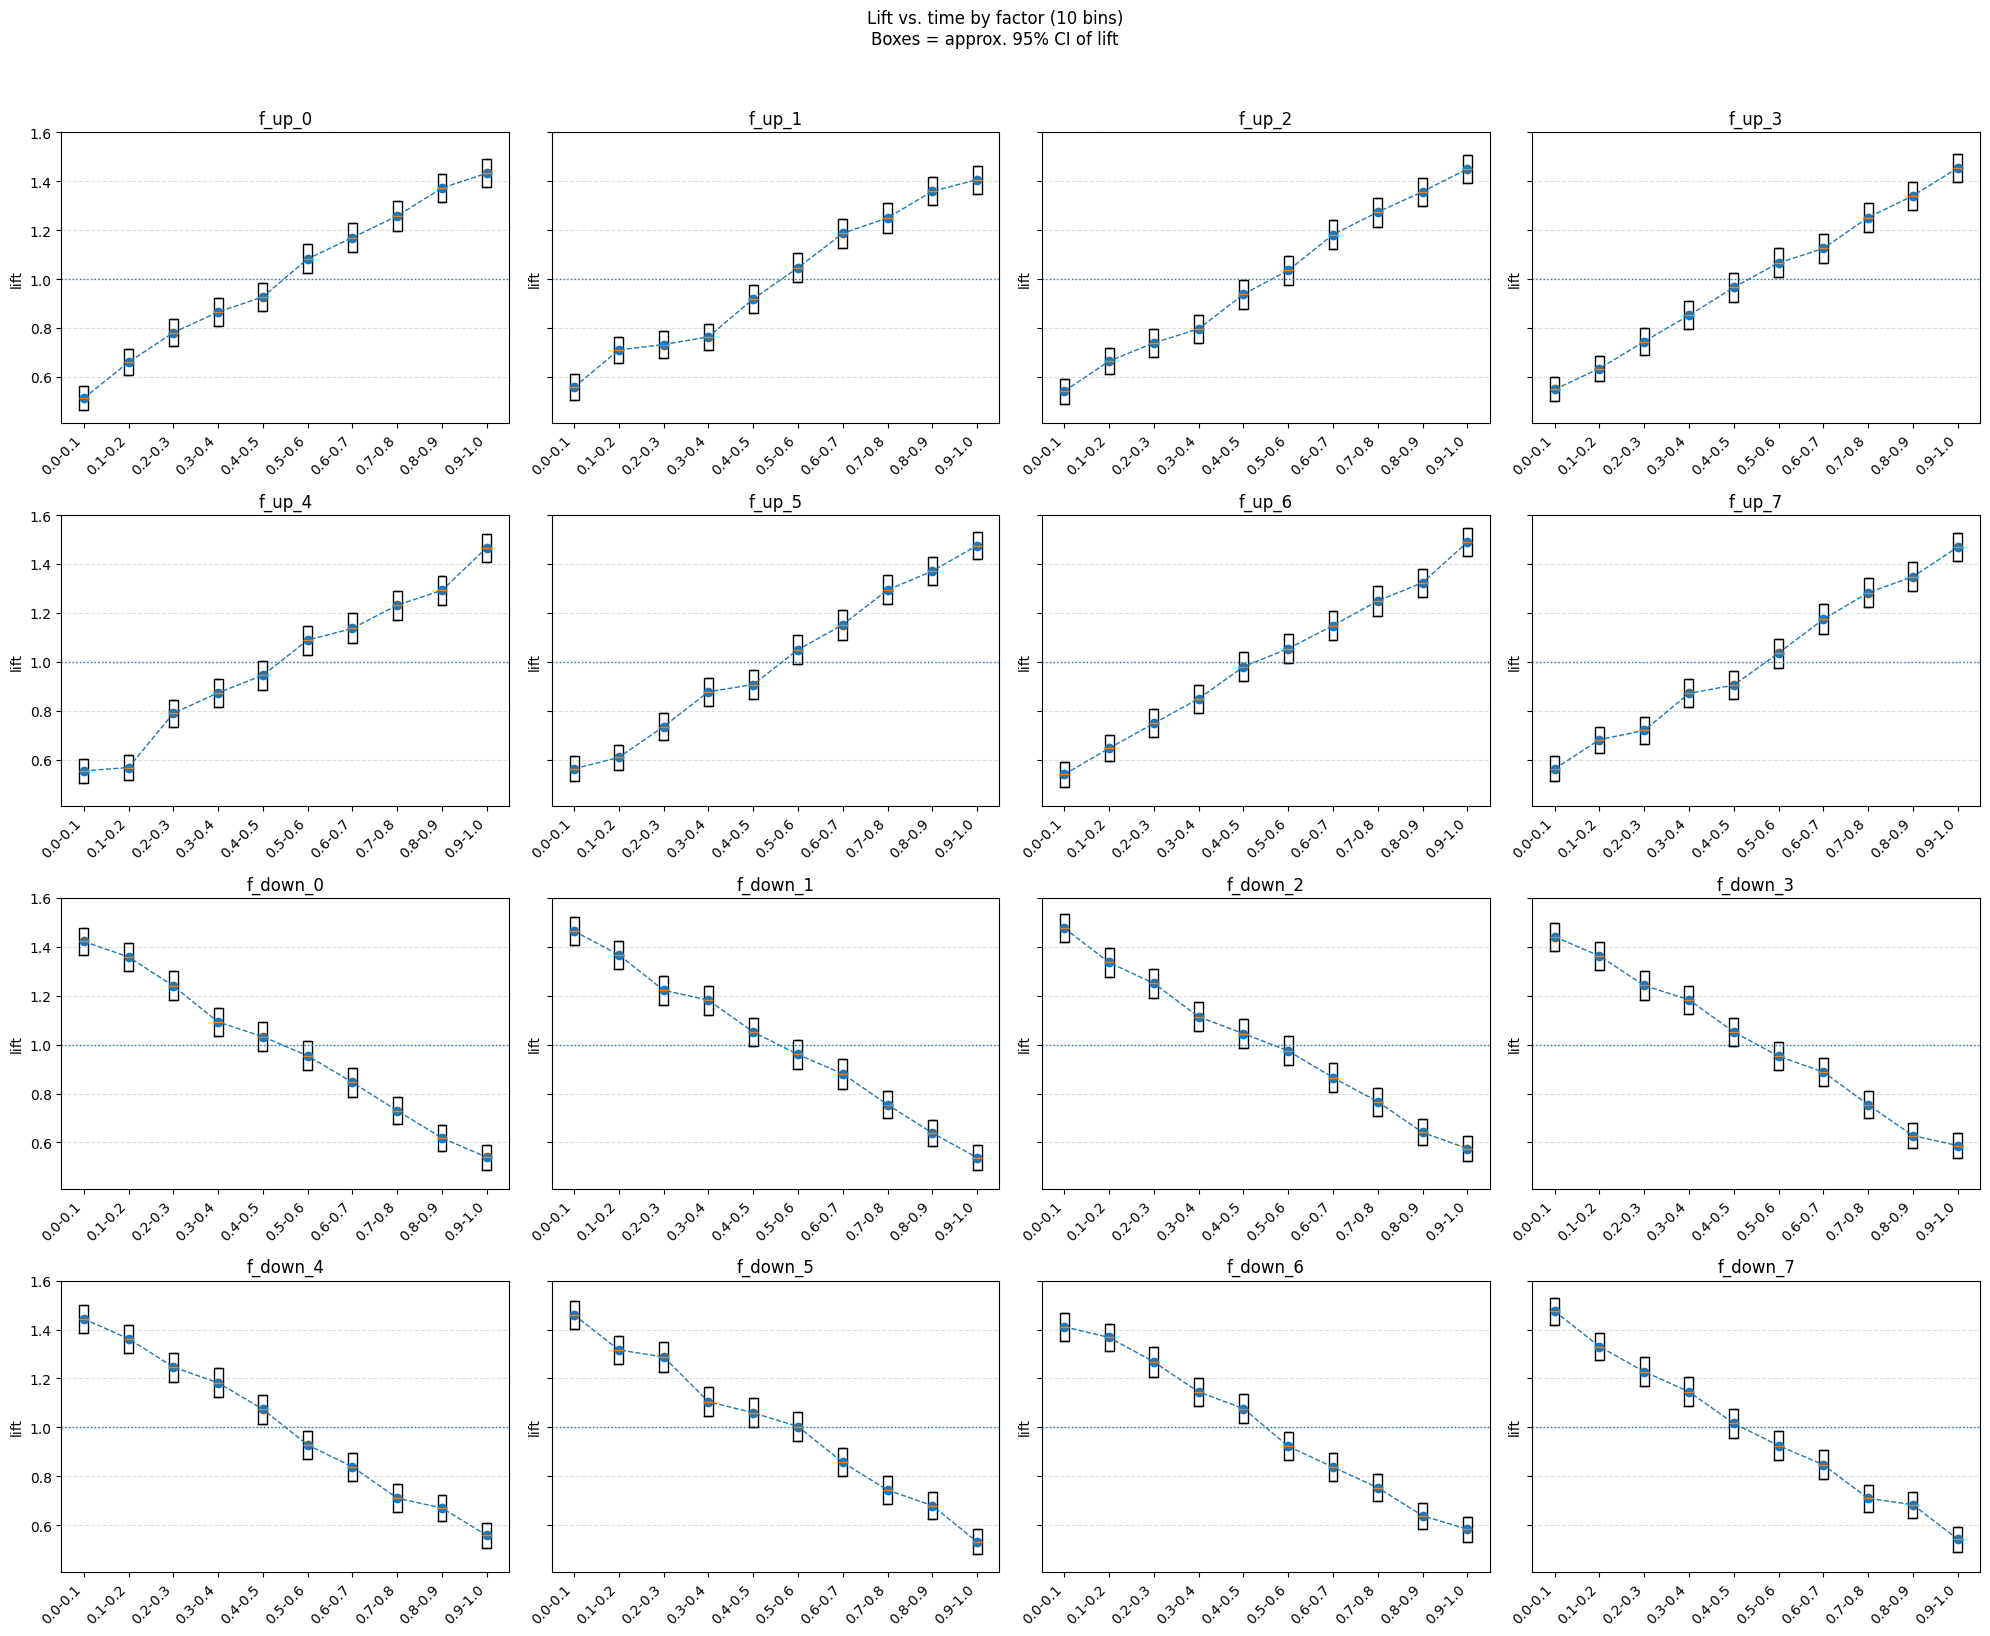

In [14]:
# --- binning ----------------------------------------------------------
bins = np.linspace(0, 1, 11)
bin_labels = [f"{bins[i]:.1f}-{bins[i + 1]:.1f}" for i in range(len(bins) - 1)]

df = df.copy()
df['t_bin'] = pd.cut(df['t'], bins=bins, labels=bin_labels,
                     include_lowest=True, right=True)

factors = [c for c in df.columns if c.startswith('f_up_') or c.startswith('f_down_')]

# --- base stats per time bin -----------------------------------------
base_stats = df.groupby('t_bin')['label'].agg(['mean', 'size'])
base_p = base_stats['mean']   # p_b
base_n = base_stats['size']   # n_b

lift_est = {}   # factor -> Series of lift
lift_ci  = {}   # factor -> (low, high) Series

for factor in factors:
    # stats for rows where factor == 1
    g = (df[df[factor] == 1]
         .groupby('t_bin')['label']
         .agg(['mean', 'size']))
    p_f = g['mean']   # p_f_hat
    n_f = g['size']   # n_f

    # align with all bins
    p_f = p_f.reindex(base_p.index)
    n_f = n_f.reindex(base_p.index)

    p_b = base_p
    n_b = base_n

    # lift estimate
    L = p_f / p_b

    # delta-method SE of lift (guard against n_f == 0)
    var_pf = p_f * (1 - p_f) / n_f
    var_pb = p_b * (1 - p_b) / n_b

    # where n_f == 0, set variance to NaN
    var_pf[n_f == 0] = np.nan

    var_L = (var_pf / (p_b ** 2)) + ((L ** 2) * var_pb / (p_b ** 2))
    se_L = np.sqrt(var_L)

    # 95% CI
    z = 1.96
    L_low  = L - z * se_L
    L_high = L + z * se_L

    lift_est[factor] = L
    lift_ci[factor]  = (L_low, L_high)

# --- plotting ---------------------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(20, 16), sharey=True)
axes = axes.flatten()
positions = np.arange(len(bin_labels))

for ax, factor in zip(axes, factors):
    # point estimate and CIs for this factor
    L      = lift_est[factor].reindex(bin_labels).astype(float)
    L_low, L_high = lift_ci[factor]
    L_low  = L_low.reindex(bin_labels).astype(float)
    L_high = L_high.reindex(bin_labels).astype(float)

    # build bxp stats per bin
    stats = []
    for med, lo, hi in zip(L, L_low, L_high):
        if np.isnan(med) or np.isnan(lo) or np.isnan(hi):
            stats.append({
                'med': np.nan, 'q1': np.nan, 'q3': np.nan,
                'whislo': np.nan, 'whishi': np.nan
            })
        else:
            stats.append({
                'med': float(med),
                'q1': float(lo),   # treat CI bounds as q1/q3
                'q3': float(hi),
                'whislo': float(lo),
                'whishi': float(hi)
            })

    # draw "box-CI" per bin
    ax.bxp(stats, positions=positions, widths=0.2, showfliers=False)

    # also overlay the point estimate as a line
    ax.plot(positions, L, marker='o', linestyle='--', linewidth=1)

    ax.axhline(1.0, linestyle=':', linewidth=1)
    ax.set_title(factor)
    ax.set_xticks(positions)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    ax.set_ylabel('lift')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.margins(x=0.05)

# hide unused axes if fewer than 16 factors
for ax in axes[len(factors):]:
    ax.axis('off')

fig.suptitle('Lift vs. time by factor (10 bins)\nBoxes = approx. 95% CI of lift', y=1.02)
fig.tight_layout()
plt.show()

# Model comparison (CatBoost, XGBoost, ExtraBoost)


In [15]:
feature_cols = sorted(c for c in df.columns if c.startswith('f_up_') or c.startswith('f_down_'))
inter_cols = sorted(c for c in df.columns if c.startswith('f_up_') or c.startswith('f_down_'))
# ExtraBoost uses f_up + f_down as interpolating features and basis (1, t) as extras
extra_cols: list[str] = ['f_down_' + str(i) for i in range(8)]

time_train = train_df['t'].to_numpy(np.float64)
time_test = test_df['t'].to_numpy(np.float64)
time_full = df['t'].to_numpy(np.float64)

X_train = train_df[feature_cols].to_numpy(np.float64)
y_train = train_df['label'].to_numpy(np.float64)
X_test = test_df[feature_cols].to_numpy(np.float64)
y_test = test_df['label'].to_numpy(np.float64)
X_full = df[feature_cols].to_numpy(np.float64)
y_full = df['label'].to_numpy(np.float64)

X_train_inter = train_df[inter_cols].to_numpy(np.float64)
X_test_inter = test_df[inter_cols].to_numpy(np.float64)
X_full_inter = df[inter_cols].to_numpy(np.float64)

# ExtraBoost extrapolates with basis features e_1=1, e_2=t
X_train_extra_ext = np.stack([np.ones_like(time_train), time_train], axis=1)
X_test_extra_ext = np.stack([np.ones_like(time_test), time_test], axis=1)
X_full_extra_ext = np.stack([np.ones_like(time_full), time_full], axis=1)


In [16]:
# Bayes-optimal probability P(L=1 | F_up, F_down, t)
eps = 1e-12
prior = 0.5
gamma_up_full = 0.5 + time_full
gamma_down_full = 1.5 - time_full
beta_const = 2 * 1 / 16

prob_up_given1 = np.clip(beta_const * gamma_up_full, eps, 1 - eps)
prob_up_given0 = np.clip((beta_const - alpha * beta_const * gamma_up_full) / (1 - alpha), eps, 1 - eps)
prob_down_given1 = np.clip(beta_const * gamma_down_full, eps, 1 - eps)
prob_down_given0 = np.clip((beta_const - alpha * beta_const * gamma_down_full) / (1 - alpha), eps, 1 - eps)

up_mat_full = df[[c for c in feature_cols if c.startswith('f_up_')]].to_numpy(np.float64)
down_mat_full = df[[c for c in feature_cols if c.startswith('f_down_')]].to_numpy(np.float64)

def log_bern(mat: np.ndarray, p: np.ndarray) -> np.ndarray:
    return mat * np.log(p[:, None]) + (1 - mat) * np.log(1 - p[:, None])

ll1_full = (np.log(prior)
            + log_bern(up_mat_full, prob_up_given1).sum(axis=1)
            + log_bern(down_mat_full, prob_down_given1).sum(axis=1))
ll0_full = (np.log(prior)
            + log_bern(up_mat_full, prob_up_given0).sum(axis=1)
            + log_bern(down_mat_full, prob_down_given0).sum(axis=1))
bayes_logit_full = ll1_full - ll0_full
bayes_optimal_full = 1.0 / (1.0 + np.exp(-bayes_logit_full))


In [17]:
build_shared()

cat_model = CatBoostClassifier(
    iterations=150,
    depth=6,
    learning_rate=0.2,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
)
cat_model.fit(X_train, y_train)

xgb_params = {
    'max_depth': 6,
    'eta': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
}
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_model = xgb.train(xgb_params, xgb_train, num_boost_round=150, verbose_eval=False)

extra_params = BoosterParams(
    n_stages=150,
    max_depth=6,
    learning_rate=0.2,
    loss='logloss',
    threads_num=4,
)
extra_model = ExtraBooster.train(X_train_inter, X_train_extra_ext, y_train, params=extra_params)

preds_full = {
    'catboost': cat_model.predict_proba(X_full)[:, 1],
    'xgboost': xgb_model.predict(xgb.DMatrix(X_full)),
    'extra_boost': extra_model.predict(X_full_inter, X_full_extra_ext),
    'bayes_optimal': bayes_optimal_full,
    'ideal_oracle': y_full,
}


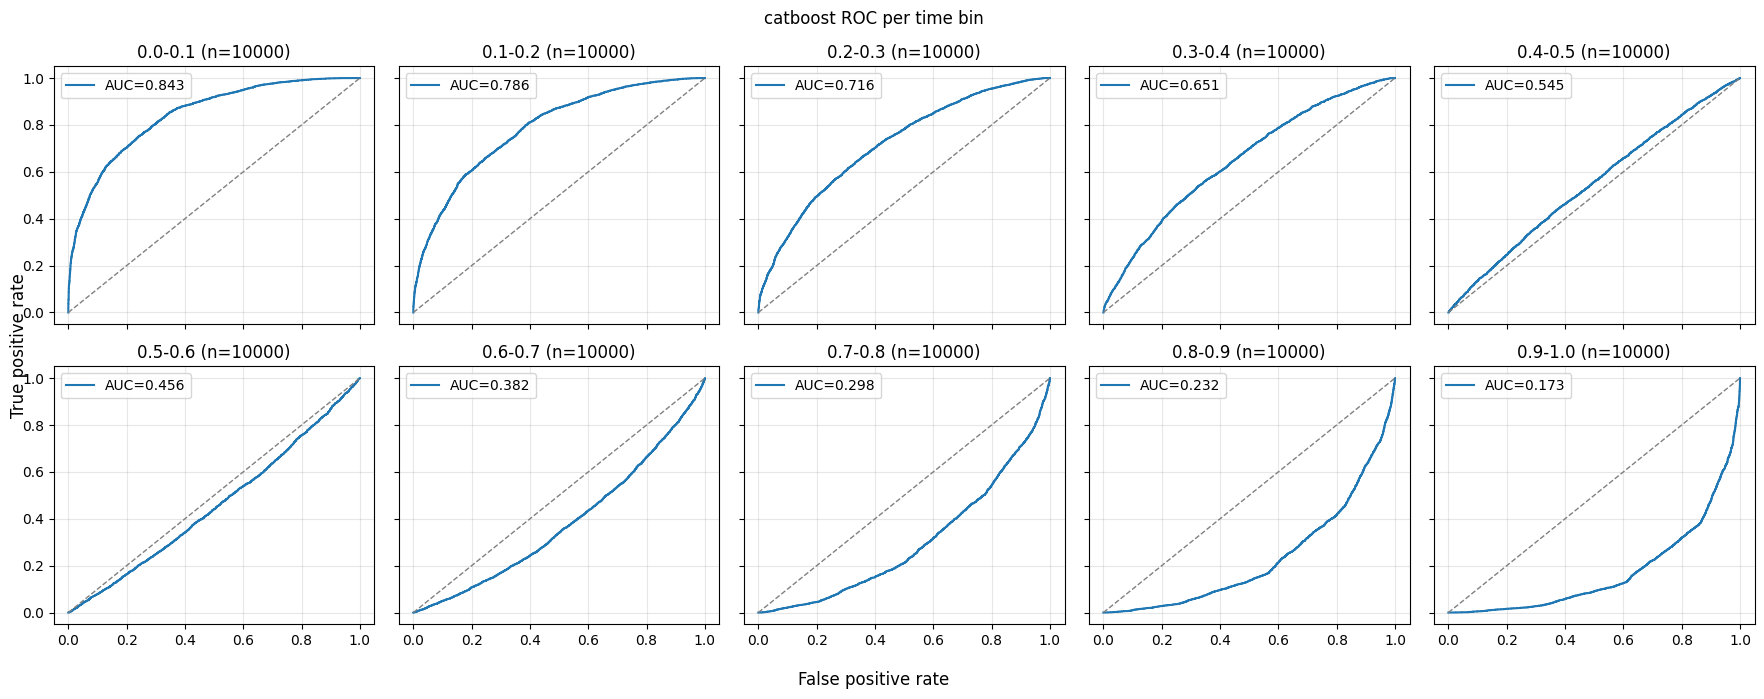

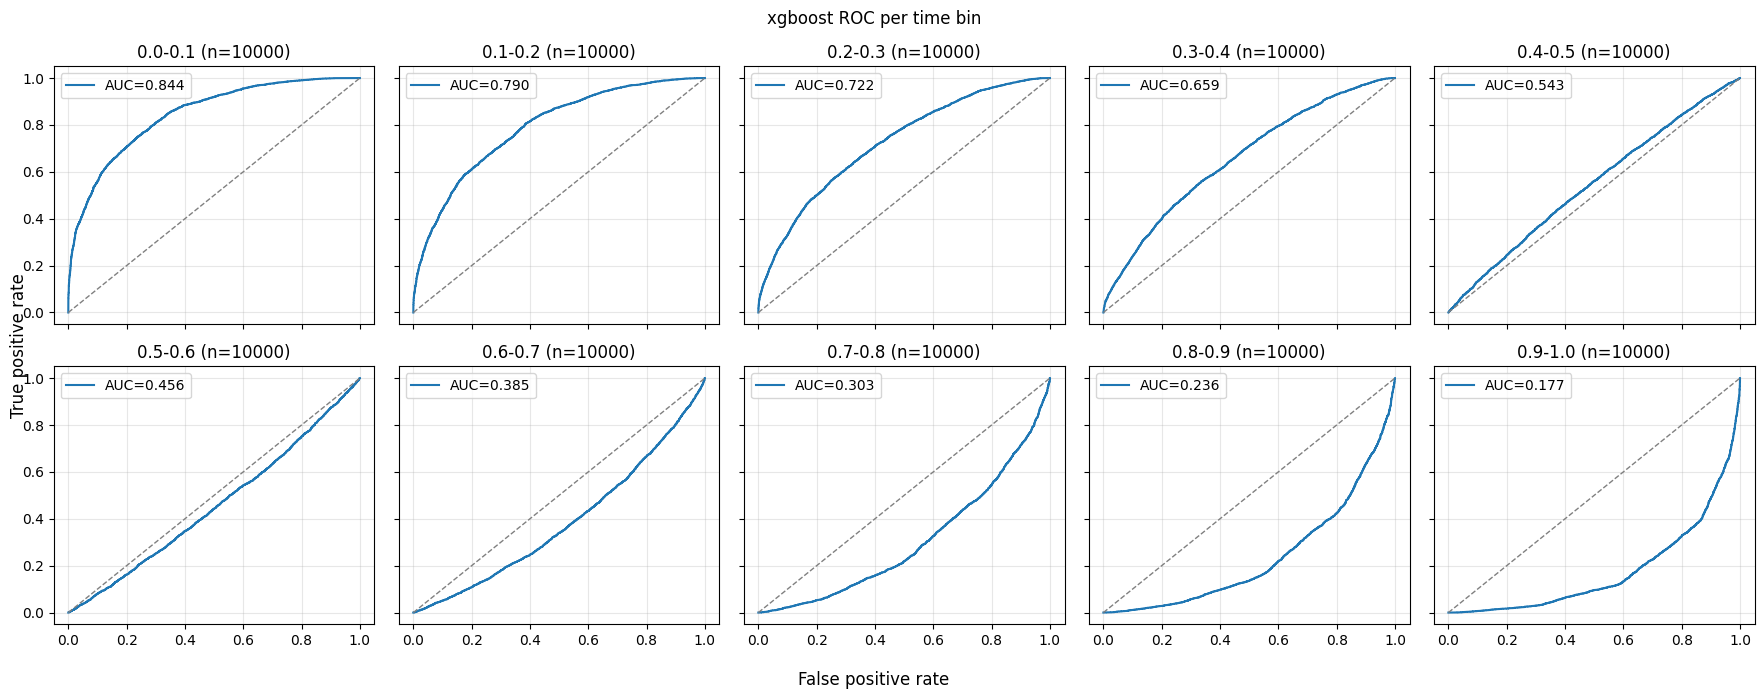

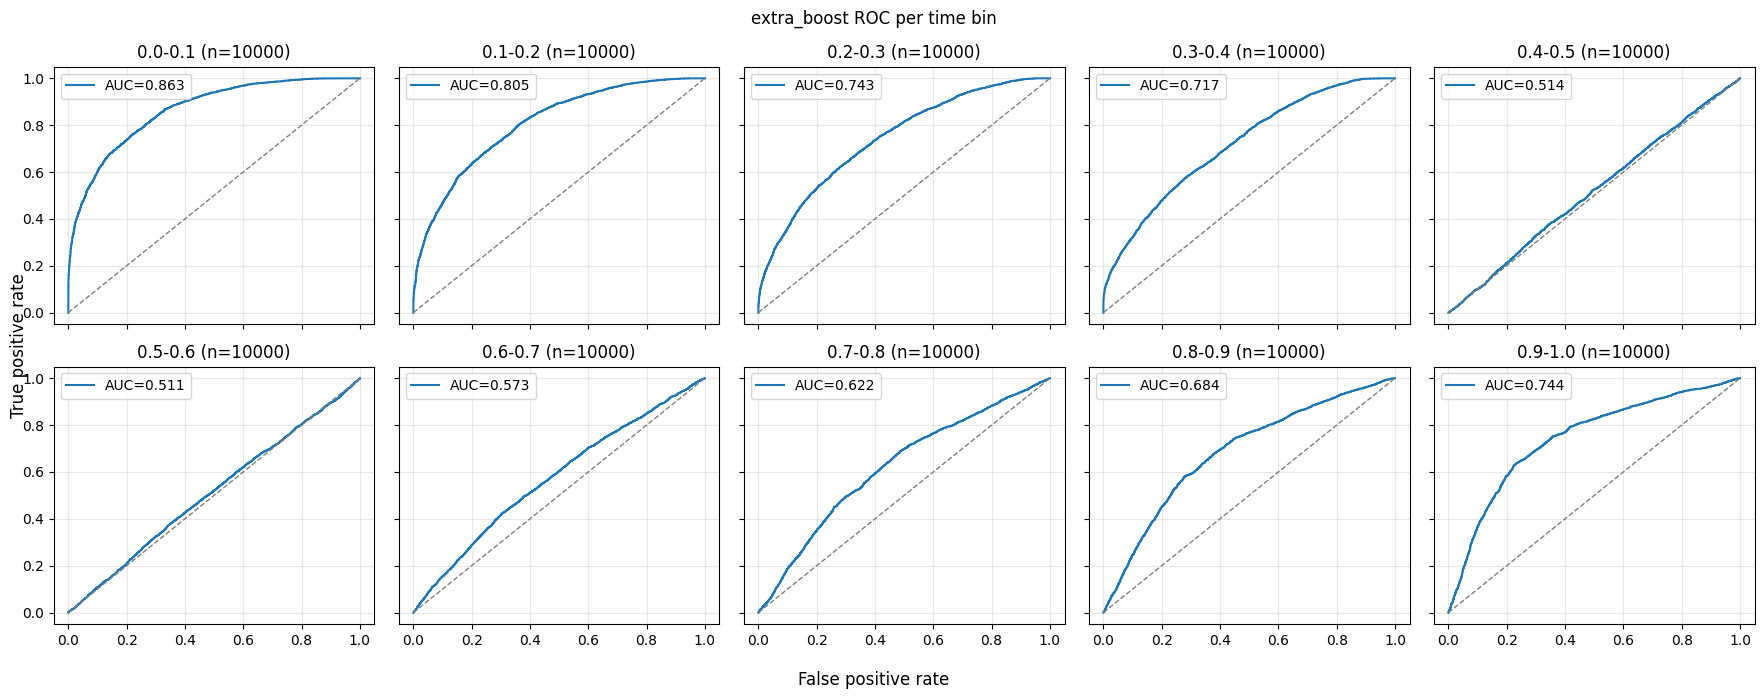

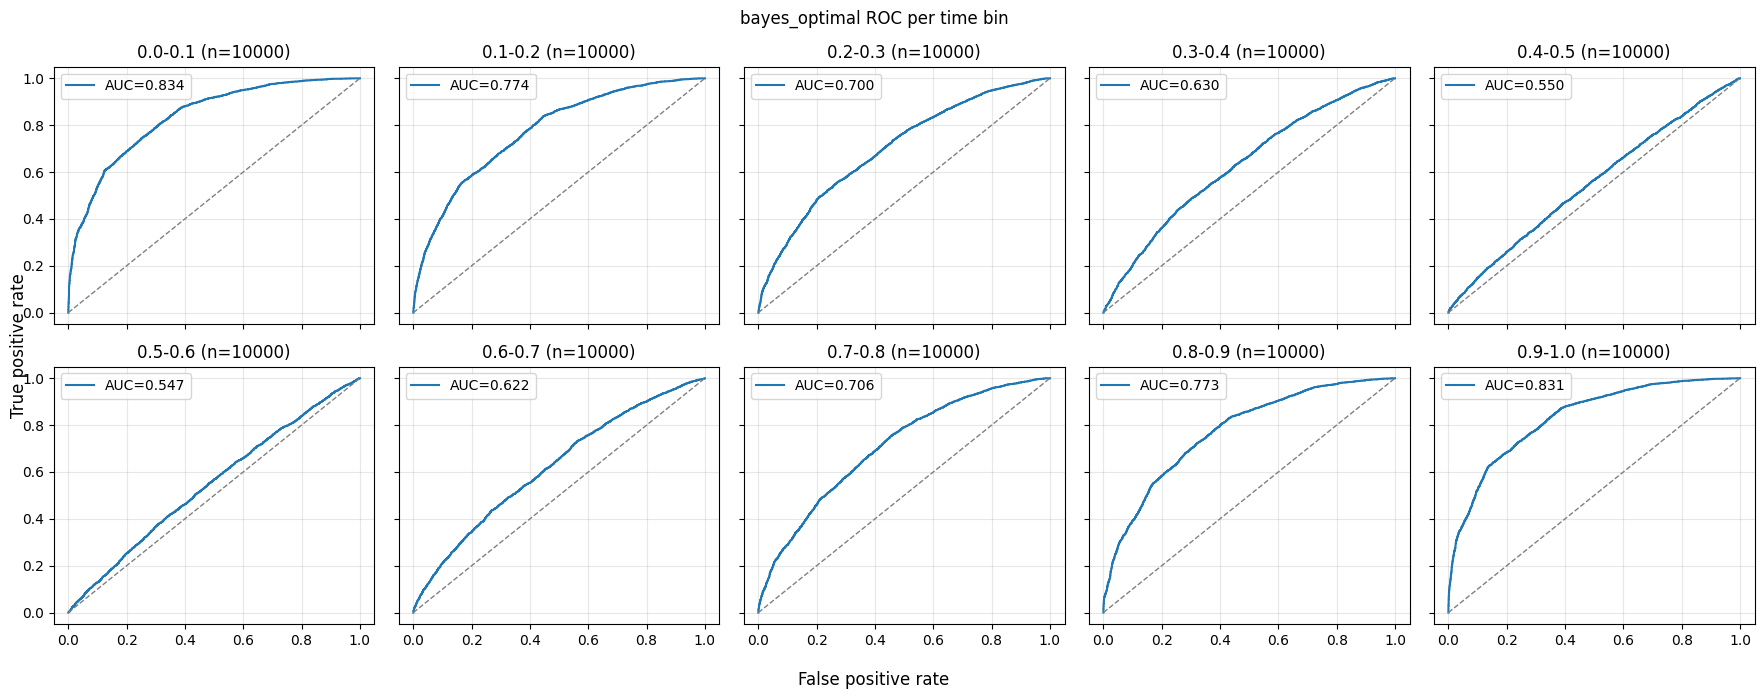

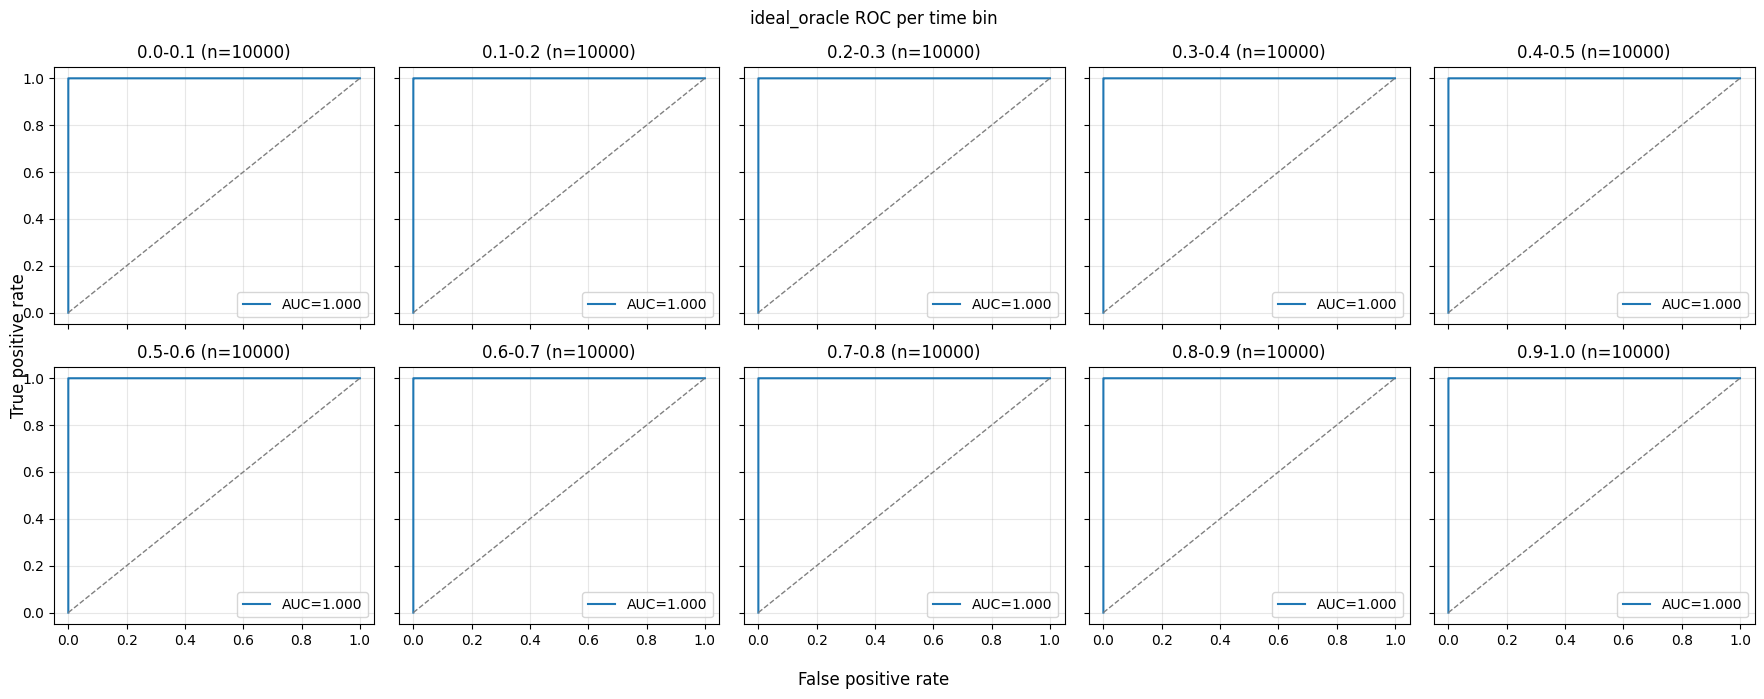

,catboost,xgboost,extra_boost,bayes_optimal,ideal_oracle
0.0-0.1,0.842507,0.843815,0.863424,0.834194,1.0
0.1-0.2,0.786469,0.789602,0.805449,0.773699,1.0
0.2-0.3,0.715899,0.721913,0.742558,0.699860,1.0
0.3-0.4,0.650623,0.658543,0.717129,0.630202,1.0
0.4-0.5,0.544643,0.543424,0.514391,0.550312,1.0
0.5-0.6,0.456029,0.456134,0.511227,0.546777,1.0
0.6-0.7,0.382118,0.385095,0.573150,0.621852,1.0
0.7-0.8,0.298189,0.303026,0.622248,0.706427,1.0
0.8-0.9,0.232101,0.235977,0.684118,0.772594,1.0
0.9-1.0,0.172972,0.177208,0.743602,0.830534,1.0


In [18]:
if 'roc_curve_np' not in globals():
    def roc_curve_np(y_true: np.ndarray, y_score: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        y_true = np.asarray(y_true, dtype=np.float64)
        y_score = np.asarray(y_score, dtype=np.float64)
        pos = (y_true == 1).sum()
        neg = (y_true == 0).sum()
        if pos == 0 or neg == 0:
            return np.array([np.nan]), np.array([np.nan])
        order = np.argsort(-y_score, kind='mergesort')
        y_sorted = y_true[order]
        tps = np.cumsum(y_sorted)
        fps = np.cumsum(1 - y_sorted)
        tps = np.concatenate([[0], tps])
        fps = np.concatenate([[0], fps])
        tpr = tps / pos
        fpr = fps / neg
        return fpr, tpr

if 't_bins' not in globals():
    bin_edges = np.linspace(0, 1, 11)
    bin_labels = [f"{bin_edges[i]:.1f}-{bin_edges[i + 1]:.1f}" for i in range(len(bin_edges) - 1)]
    t_bins = pd.cut(df['t'], bins=bin_edges, labels=bin_labels, include_lowest=True, right=True)

results = {}
for name, pred in preds_full.items():
    bin_entries = []
    for label in bin_labels:
        mask = (t_bins == label).to_numpy()
        y_bin = y_full[mask]
        p_bin = pred[mask]
        if mask.sum() < 2 or len(np.unique(y_bin)) < 2:
            bin_auc = np.nan
            fpr = np.array([np.nan])
            tpr = np.array([np.nan])
        else:
            bin_auc = roc_auc_score(y_bin, p_bin)
            fpr, tpr = roc_curve_np(y_bin, p_bin)
        bin_entries.append({
            'label': label,
            'auc': bin_auc,
            'fpr': fpr,
            'tpr': tpr,
            'n': int(mask.sum()),
        })
    results[name] = bin_entries

# One figure per model, 10 ROC plots (one per time bin)
for name, bins_data in results.items():
    fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True)
    axes = axes.flatten()
    for ax, entry in zip(axes, bins_data):
        fpr, tpr = entry['fpr'], entry['tpr']
        auc = entry['auc']
        label = entry['label']
        n = entry['n']
        if np.isnan(auc) or np.isnan(fpr).all():
            ax.text(0.5, 0.5, 'insufficient data', ha='center', va='center')
        else:
            ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
            ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
            ax.legend()
        ax.set_title(f"{label} (n={n})")
        ax.grid(alpha=0.3)
    fig.suptitle(f"{name} ROC per time bin")
    fig.supxlabel('False positive rate')
    fig.supylabel('True positive rate')
    fig.tight_layout()
    plt.show()

# Tabular AUCs per bin
pd.DataFrame({
    name: [entry['auc'] for entry in bins_data]
    for name, bins_data in results.items()
}, index=bin_labels)


# Extra Boost

# ExtraBoost detailed analysis


/tmp/ipykernel_44130/847260772.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = extra_df.groupby('t_bin').mean().reindex(bin_labels)


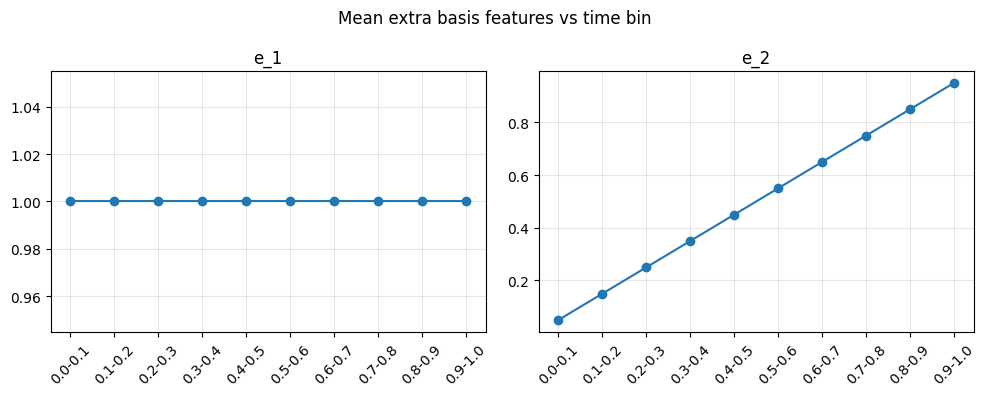

,e_1,e_2
t_bin,,
0.0-0.1,1.0,0.049995
0.1-0.2,1.0,0.149996
0.2-0.3,1.0,0.249997
0.3-0.4,1.0,0.349998
0.4-0.5,1.0,0.449999
0.5-0.6,1.0,0.550001
0.6-0.7,1.0,0.650002
0.7-0.8,1.0,0.750003
0.8-0.9,1.0,0.850004


In [19]:
# Mean of extra features (basis) by time bin
extra_feature_names = ['e_1', 'e_2']
extra_full = np.stack([np.ones_like(time_full), time_full], axis=1)

extra_df = pd.DataFrame(extra_full, columns=extra_feature_names)
extra_df['t_bin'] = t_bins
mean_by_bin = extra_df.groupby('t_bin').mean().reindex(bin_labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
axes = axes.flatten()
for ax, name in zip(axes, extra_feature_names):
    ax.plot(bin_labels, mean_by_bin[name], marker='o')
    ax.set_title(name)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
fig.suptitle('Mean extra basis features vs time bin')
fig.tight_layout()
plt.show()

mean_by_bin


Saved ExtraBoost model to /home/tarstars/prj/extra_bridged_boosting/notebooks/logloss_mode/gbdte_model.json (RecordIds removed)
Rendered 32 trees to /home/tarstars/prj/extra_bridged_boosting/notebooks/logloss_mode/sixteen_stage_trees


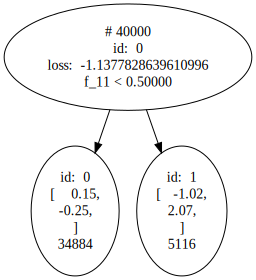

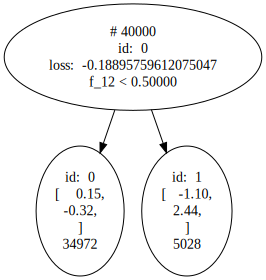

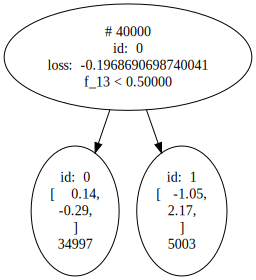

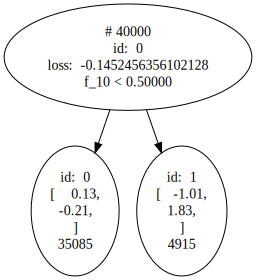

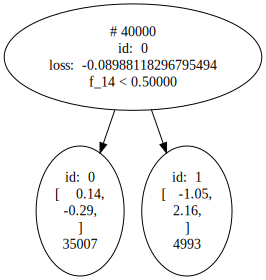

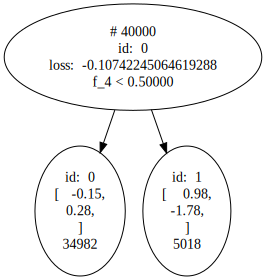

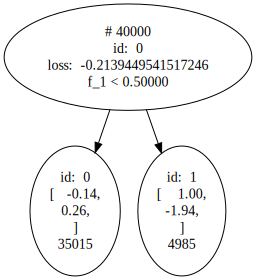

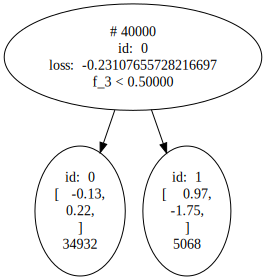

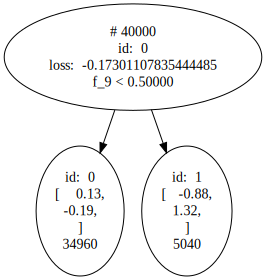

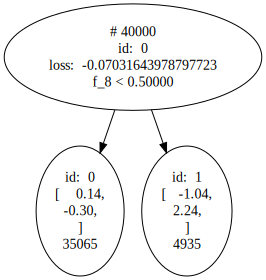

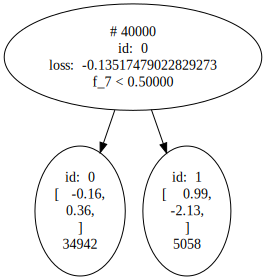

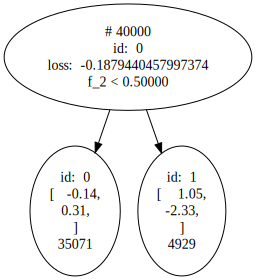

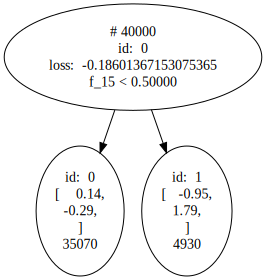

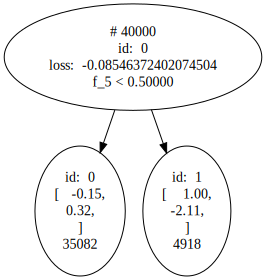

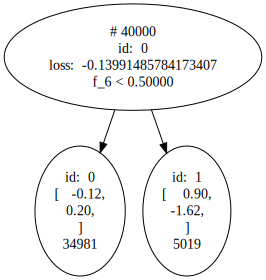

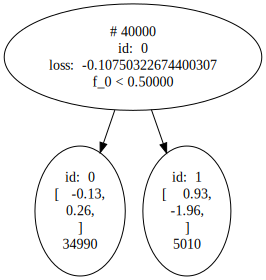

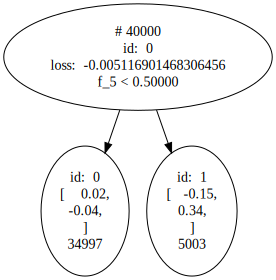

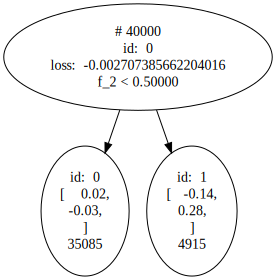

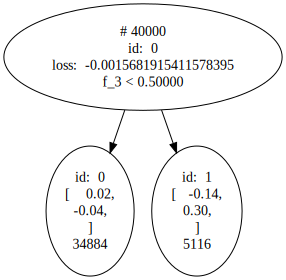

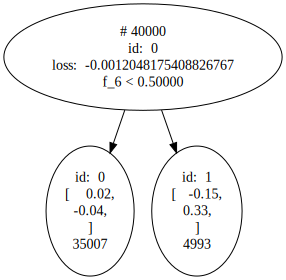

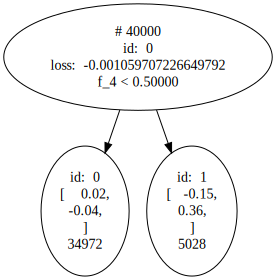

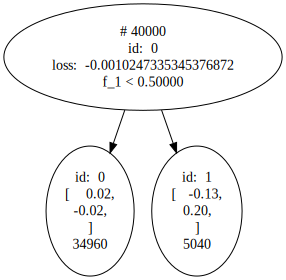

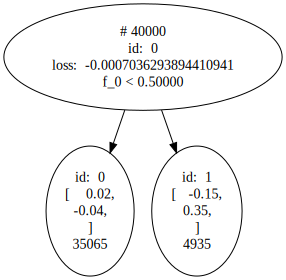

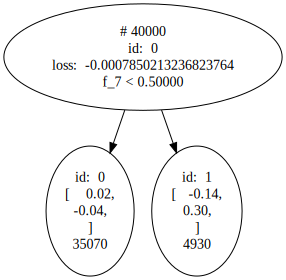

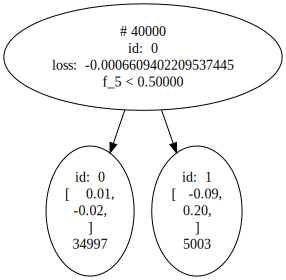

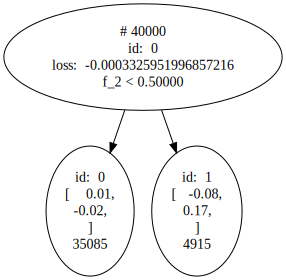

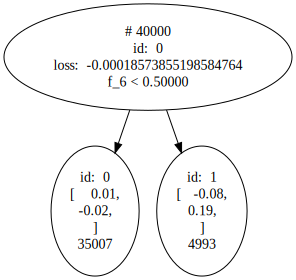

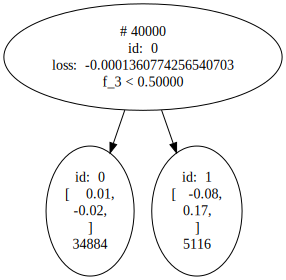

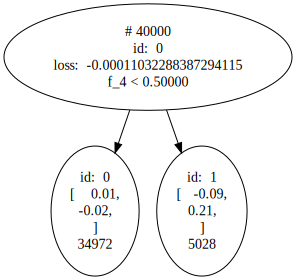

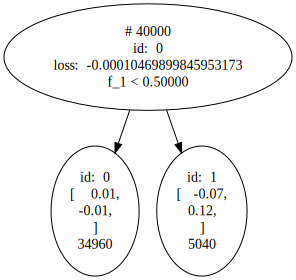

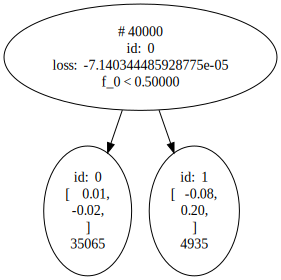

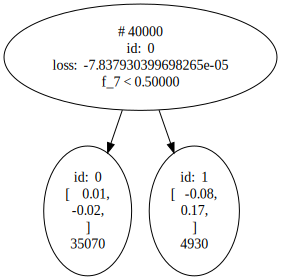

overall auc 0.7109286431034754


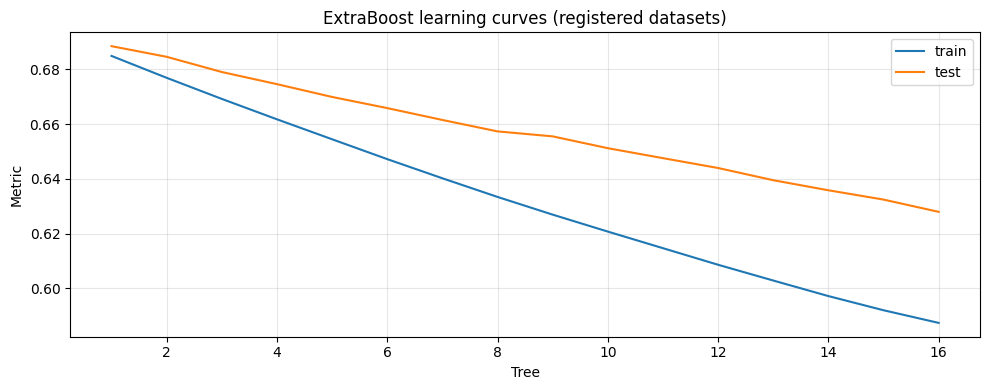

,train,test
tree,,
11,0.608602,0.643976
12,0.602838,0.639515
13,0.597156,0.635836
14,0.591975,0.632432
15,0.587350,0.627948


In [20]:
# Re-train ExtraBoost (adjust params here)
extra_play_params = BoosterParams(
    n_stages=16,
    max_depth=1,
    learning_rate=1.0,
    unbalanced_loss=0.0,
    loss='logloss',
    threads_num=16,
)

monitor_datasets = [
    (X_train_inter, X_train_extra_ext, y_train, 'train'),
    (X_test_inter, X_test_extra_ext, y_test, 'test'),
]

extra_play = ExtraBooster.train(
    X_train_inter,
    X_train_extra_ext,
    y_train,
    params=extra_play_params,
    monitor_datasets=monitor_datasets,
)

model_path = output_dir / 'gbdte_model.json'
extra_play.save(str(model_path))
# Strip RecordIds from the saved JSON for portability
with open(model_path, 'r', encoding='utf-8') as f:
    model_json = json.load(f)
for tree in model_json.get('Trees', []):
    for leaf in tree.get('LeafNodes', []):
        leaf.pop('RecordIds', None)
with open(model_path, 'w', encoding='utf-8') as f:
    json.dump(model_json, f, ensure_ascii=False, indent=2)
print(f"Saved ExtraBoost model to {model_path} (RecordIds removed)")

tree_dir = output_dir / 'sixteen_stage_trees'
extra_play.render_trees(prefix='stage', figure_type='svg', directory=tree_dir)
tree_paths = sorted(tree_dir.glob('stage_*.svg'))
print(f"Rendered {len(tree_paths)} trees to {tree_dir}")
for path in tree_paths:
    display(SVG(filename=str(path)))

extra_preds_full = extra_play.predict(X_full_inter, X_full_extra_ext)
extra_overall_auc = roc_auc_score(y_full, extra_preds_full)
print("overall auc", extra_overall_auc)


# Learning curves for ExtraBoost (play run)
lc_path = output_dir / 'extra_play_learning_curves.json'
extra_play.dump_learning_curves(str(lc_path))

with open(lc_path, 'r', encoding='utf-8') as f:
    lc_data = json.load(f)

lc_df = pd.DataFrame(lc_data['Values'], columns=lc_data['Titles'])
lc_df.index.name = 'tree'

fig, ax = plt.subplots(figsize=(10, 4))
for col in lc_df.columns:
    ax.plot(lc_df.index + 1, lc_df[col], label=col)
ax.set_xlabel('Tree')
ax.set_ylabel('Metric')
ax.set_title('ExtraBoost learning curves (registered datasets)')
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

lc_df.tail()


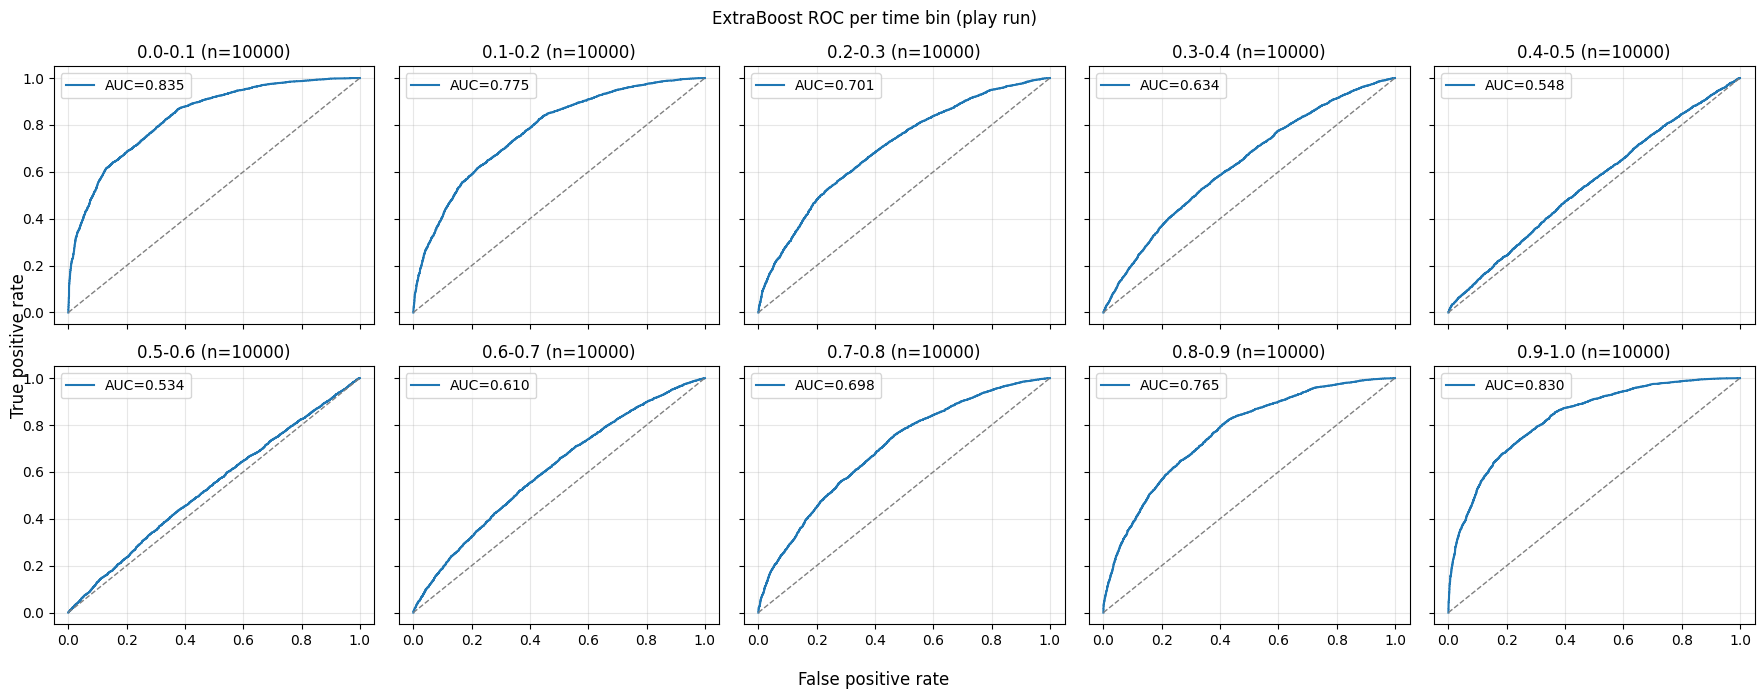

In [21]:
# ROC per bin for ExtraBoost (play)
extra_bin_entries = []
for label in bin_labels:
    mask = (t_bins == label).to_numpy()
    y_bin = y_full[mask]
    p_bin = extra_preds_full[mask]
    if mask.sum() < 2 or len(np.unique(y_bin)) < 2:
        bin_auc = np.nan
        fpr = np.array([np.nan])
        tpr = np.array([np.nan])
    else:
        bin_auc = roc_auc_score(y_bin, p_bin)
        fpr, tpr = roc_curve_np(y_bin, p_bin)
    extra_bin_entries.append({'label': label, 'auc': bin_auc, 'fpr': fpr, 'tpr': tpr, 'n': int(mask.sum())})

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True)
axes = axes.flatten()
for ax, entry in zip(axes, extra_bin_entries):
    fpr, tpr, auc = entry['fpr'], entry['tpr'], entry['auc']
    if np.isnan(auc) or np.isnan(fpr).all():
        ax.text(0.5, 0.5, 'insufficient data', ha='center', va='center')
    else:
        ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
        ax.legend()
    ax.set_title(f"{entry['label']} (n={entry['n']})")
    ax.grid(alpha=0.3)
fig.suptitle('ExtraBoost ROC per time bin (play run)')
fig.supxlabel('False positive rate')
fig.supylabel('True positive rate')
fig.tight_layout()
plt.show()


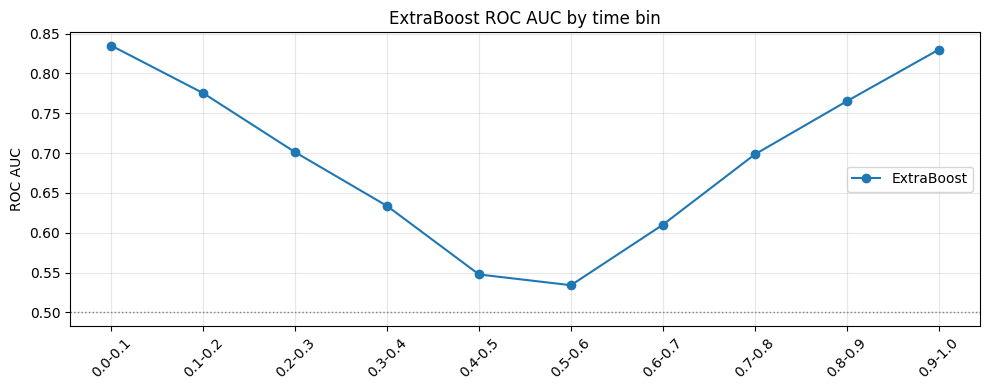

In [22]:
# ExtraBoost AUC by bin (play run)
extra_bin_auc = [entry['auc'] for entry in extra_bin_entries]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bin_labels, extra_bin_auc, marker='o', label='ExtraBoost')
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
ax.set_ylabel('ROC AUC')
ax.set_title('ExtraBoost ROC AUC by time bin')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

pd.Series(extra_bin_auc, index=bin_labels, name='extra_boost_auc')

extra_play.close()


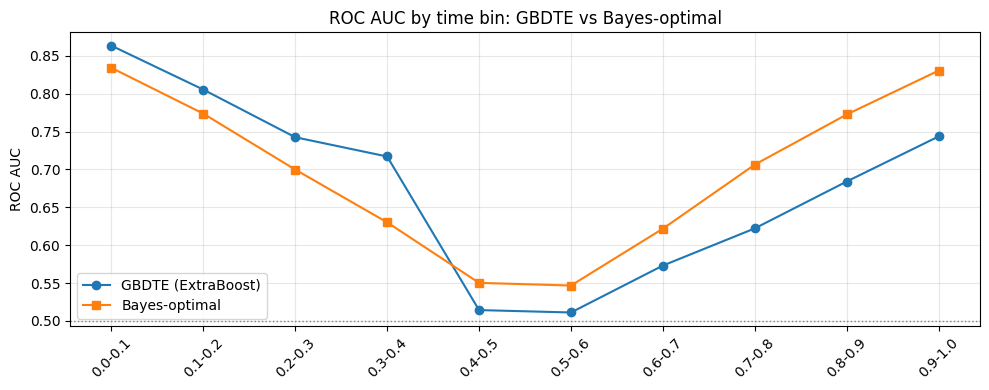

,gbdte,bayes_optimal
0.0-0.1,0.863424,0.834194
0.1-0.2,0.805449,0.773699
0.2-0.3,0.742558,0.699860
0.3-0.4,0.717129,0.630202
0.4-0.5,0.514391,0.550312
0.5-0.6,0.511227,0.546777
0.6-0.7,0.573150,0.621852
0.7-0.8,0.622248,0.706427
0.8-0.9,0.684118,0.772594
0.9-1.0,0.743602,0.830534


In [23]:
# Bayes-optimal vs GBDTE ROC AUC by time bin
extra_bin_auc = [entry['auc'] for entry in results['extra_boost']]
bayes_bin_auc = [entry['auc'] for entry in results['bayes_optimal']]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bin_labels, extra_bin_auc, marker='o', label='GBDTE (ExtraBoost)')
ax.plot(bin_labels, bayes_bin_auc, marker='s', label='Bayes-optimal')
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC by time bin: GBDTE vs Bayes-optimal')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

pd.DataFrame({'gbdte': extra_bin_auc, 'bayes_optimal': bayes_bin_auc}, index=bin_labels)


# Optimal model

/tmp/ipykernel_44130/3028823613.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)


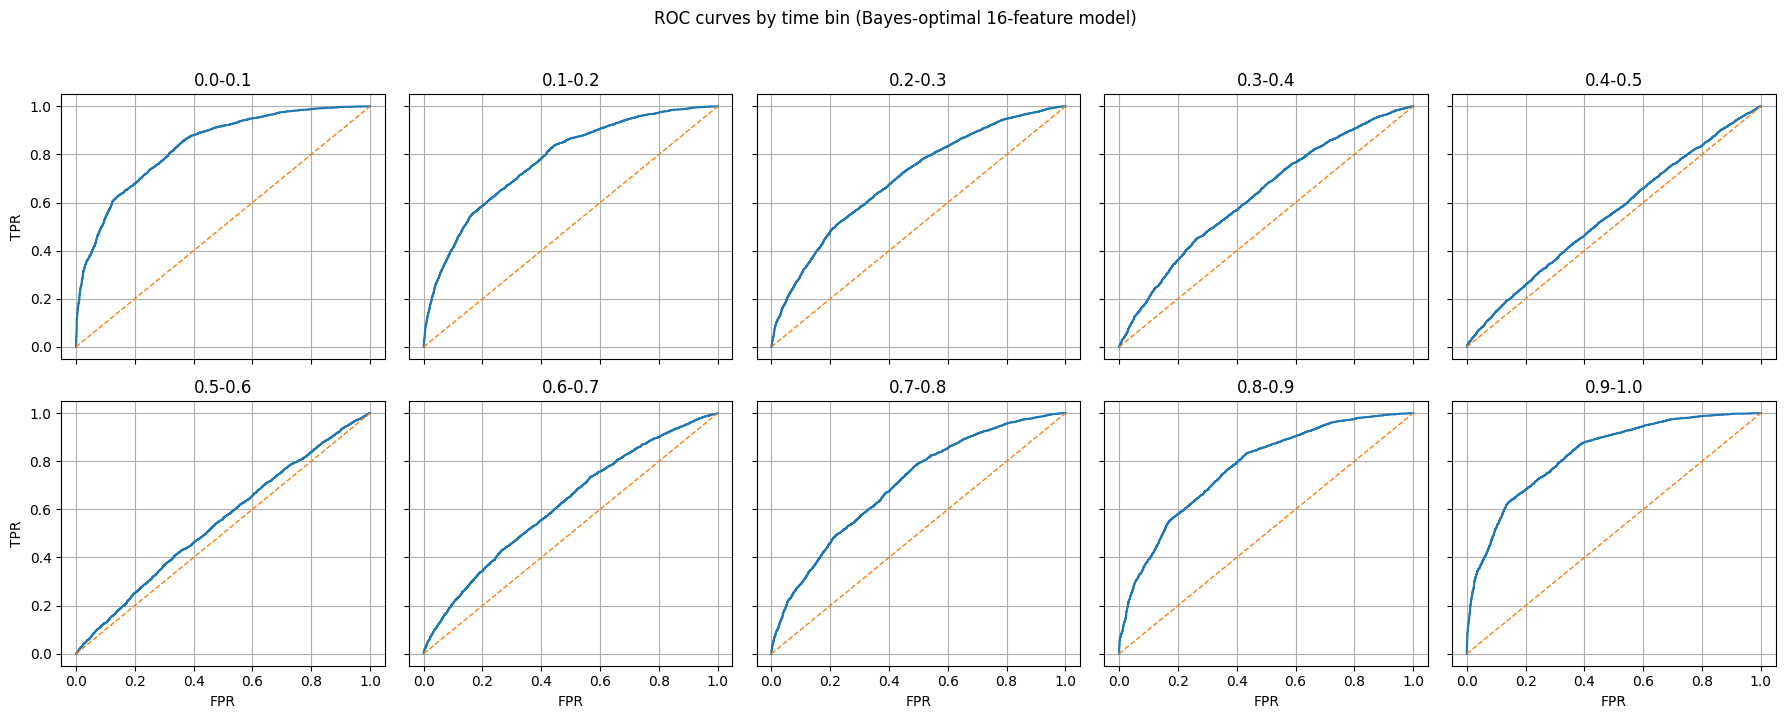

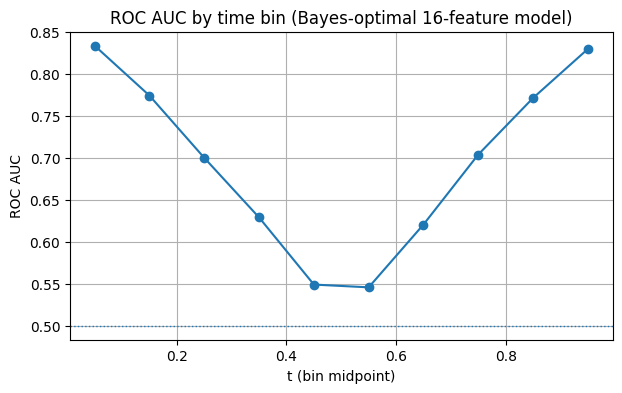

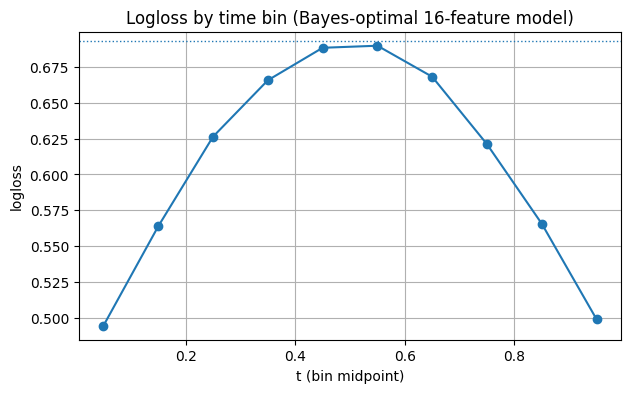

Overall ROC AUC (all times, optimal model): 0.7137


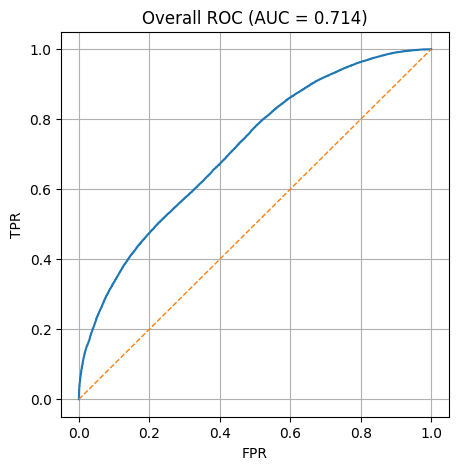

In [24]:
# -------------------------------------------------------
# 1. Bayes-optimal model using all 16 factors + time
# -------------------------------------------------------

# Parameters used in the generator
alpha = 0.5               # base rate P(L=1 | t)
beta = 2 * 1/16           # coverage per factor = 1/8

def gamma_up(t):
    return 0.5 + t        # ratio lift for up-factors

def gamma_down(t):
    return 1.5 - t        # ratio lift for down-factors

# Per-factor probabilities used in the generator
def p_up_1(t):  # P(f_up = 1 | L=1, t)
    return beta * gamma_up(t)

def p_up_0(t):  # P(f_up = 1 | L=0, t)
    return (beta - alpha * beta * gamma_up(t)) / (1 - alpha)

def p_down_1(t):  # P(f_down = 1 | L=1, t)
    return beta * gamma_down(t)

def p_down_0(t):  # P(f_down = 1 | L=0, t)
    return (beta - alpha * beta * gamma_down(t)) / (1 - alpha)


# Counts of active up/down factors per row
up_cols = [c for c in df.columns if c.startswith("f_up_")]
down_cols = [c for c in df.columns if c.startswith("f_down_")]

U = df[up_cols].sum(axis=1).to_numpy()     # number of up-factors == 1
D = df[down_cols].sum(axis=1).to_numpy()   # number of down-factors == 1
t_vals = df["t"].to_numpy()

# Compute log-odds z(t, f1..f16) exactly from the generative model
pu1 = p_up_1(t_vals)
pu0 = p_up_0(t_vals)
pd1 = p_down_1(t_vals)
pd0 = p_down_0(t_vals)

llr_u1 = np.log(pu1 / pu0)
llr_u0 = np.log((1 - pu1) / (1 - pu0))
llr_d1 = np.log(pd1 / pd0)
llr_d0 = np.log((1 - pd1) / (1 - pd0))

# Total log-odds: intercept term cancels, only counts matter
z = U * llr_u1 + (8 - U) * llr_u0 + D * llr_d1 + (8 - D) * llr_d0

p_opt = 1.0 / (1.0 + np.exp(-z))   # Bayes-optimal P(L=1 | t, f1..f16)
df["p_opt"] = p_opt

# -------------------------------------------------------
# 2. Helper functions for ROC / AUC
# -------------------------------------------------------

def roc_curve_manual(y_true, scores):
    order = np.argsort(-scores)
    y = y_true[order]
    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        # Degenerate case (all positives or all negatives)
        return np.array([0.0, 1.0]), np.array([0.0, 1.0])
    tps = np.cumsum(y)
    fps = np.cumsum(1 - y)
    tpr = tps / P
    fpr = fps / N
    fpr = np.concatenate([[0.0], fpr])
    tpr = np.concatenate([[0.0], tpr])
    return fpr, tpr

def auc_trapz(fpr, tpr):
    return np.trapz(tpr, fpr)

# -------------------------------------------------------
# 3. Bin in time and compute per-bin metrics
# -------------------------------------------------------

bins = np.linspace(0, 1, 11)  # 0-0.1, 0.1-0.2, ..., 0.9-1.0
bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]

df["t_bin"] = pd.cut(df["t"], bins=bins, labels=bin_labels,
                     include_lowest=True, right=True)

rows = []
roc_by_bin = {}
eps = 1e-15

for bl in bin_labels:
    df_bin = df[df["t_bin"] == bl]
    y_true = df_bin["label"].to_numpy()
    scores = df_bin["p_opt"].to_numpy()

    fpr, tpr = roc_curve_manual(y_true, scores)
    roc_by_bin[bl] = (fpr, tpr)
    auc = auc_trapz(fpr, tpr)

    p = np.clip(scores, eps, 1 - eps)
    logloss = -(y_true * np.log(p) + (1 - y_true) * np.log(1 - p)).mean()

    rows.append({
        "t_bin": bl,
        "n": len(df_bin),
        "roc_auc": auc,
        "logloss": logloss,
    })

metrics = pd.DataFrame(rows)

# -------------------------------------------------------
# 4. ROC for each time bin
# -------------------------------------------------------

fig_roc, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True)
axes = axes.flatten()

for i, bl in enumerate(bin_labels):
    ax = axes[i]
    fpr, tpr = roc_by_bin[bl]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title(str(bl))
    ax.grid(True)
    if i // 5 == 1:
        ax.set_xlabel("FPR")
    if i % 5 == 0:
        ax.set_ylabel("TPR")

fig_roc.suptitle("ROC curves by time bin (Bayes-optimal 16-feature model)", y=1.02)
fig_roc.tight_layout()
plt.show()

# -------------------------------------------------------
# 5. ROC AUC vs time
# -------------------------------------------------------

bin_mids = 0.5 * (bins[:-1] + bins[1:])

fig_auc, ax_auc = plt.subplots(figsize=(7, 4))
ax_auc.plot(bin_mids, metrics["roc_auc"].to_numpy(), marker="o")
ax_auc.axhline(0.5, linestyle=":", linewidth=1)
ax_auc.set_xlabel("t (bin midpoint)")
ax_auc.set_ylabel("ROC AUC")
ax_auc.set_title("ROC AUC by time bin (Bayes-optimal 16-feature model)")
ax_auc.grid(True)
plt.show()

# -------------------------------------------------------
# 6. Logloss vs time
# -------------------------------------------------------

fig_ll, ax_ll = plt.subplots(figsize=(7, 4))
ax_ll.plot(bin_mids, metrics["logloss"].to_numpy(), marker="o")
ax_ll.axhline(np.log(2), linestyle=":", linewidth=1)  # baseline logloss for p=0.5
ax_ll.set_xlabel("t (bin midpoint)")
ax_ll.set_ylabel("logloss")
ax_ll.set_title("Logloss by time bin (Bayes-optimal 16-feature model)")
ax_ll.grid(True)
plt.show()

# -------------------------------------------------------
# 7. Overall ROC and AUC (no binning)
# -------------------------------------------------------

y_all = df["label"].to_numpy()
s_all = df["p_opt"].to_numpy()
fpr_all, tpr_all = roc_curve_manual(y_all, s_all)
auc_all = auc_trapz(fpr_all, tpr_all)
print(f"Overall ROC AUC (all times, optimal model): {auc_all:.4f}")

fig_all, ax_all = plt.subplots(figsize=(5, 5))
ax_all.plot(fpr_all, tpr_all)
ax_all.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax_all.set_xlabel("FPR")
ax_all.set_ylabel("TPR")
ax_all.set_title(f"Overall ROC (AUC = {auc_all:.3f})")
ax_all.grid(True)
plt.show()
